## ANLY 5336 Analytics Project: COVID-19 Forecasting
Author: John Courtright

This project works through data from the New York Time's COVID-19 datasets. Link: https://github.com/nytimes/covid-19-data

This notebook constructs time-series models on Travis County's weekly case and death reporting over 3 years (from March 2020 to March 2023).

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [2]:
# Data Sets
travis_df = pd.read_csv('https://raw.githubusercontent.com/john-courtright/TXST-ANLY-5336-Courtright/refs/heads/main/Covid/travis_county_covid_weekly.csv')
travis_mask = pd.read_csv('https://raw.githubusercontent.com/john-courtright/TXST-ANLY-5336-Courtright/refs/heads/main/Covid/travis_county_mask_usage.csv')

In [3]:
travis_df['date'] = pd.to_datetime(travis_df['date'])
travis_df.set_index('date', inplace=True)

In [4]:
# Extract the 4 Time-Series Chunks
cases_df = travis_df['cases']
cases100k_df = travis_df['cases_avg_per_100k']
deaths_df = travis_df['deaths']
deaths100k_df = travis_df['deaths_avg_per_100k']

In [5]:
# Confirm all clean
for name, s in {
    "cases": cases_df,
    "cases100k": cases100k_df,
    "deaths": deaths_df,
    "deaths100k": deaths100k_df
}.items():
    print(f"{name}: {s.isna().sum()} missing values")

cases: 0 missing values
cases100k: 0 missing values
deaths: 0 missing values
deaths100k: 0 missing values



Decomposing: Weekly Cases


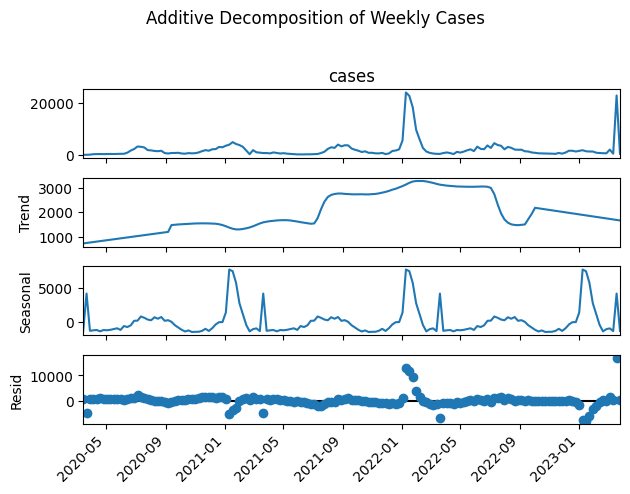


Decomposing: Weekly Cases per 100k


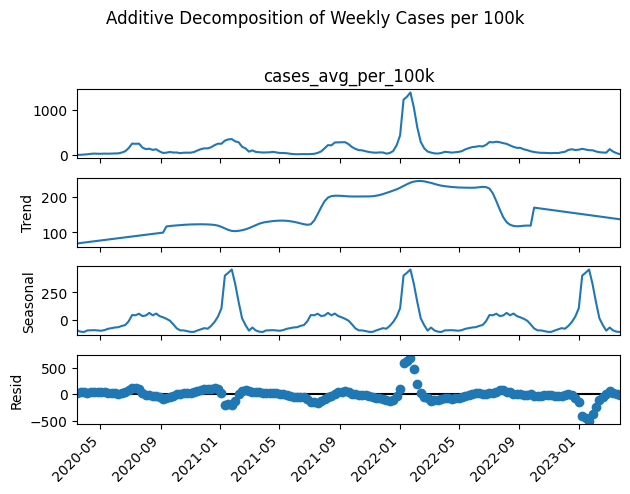


Decomposing: Weekly Deaths


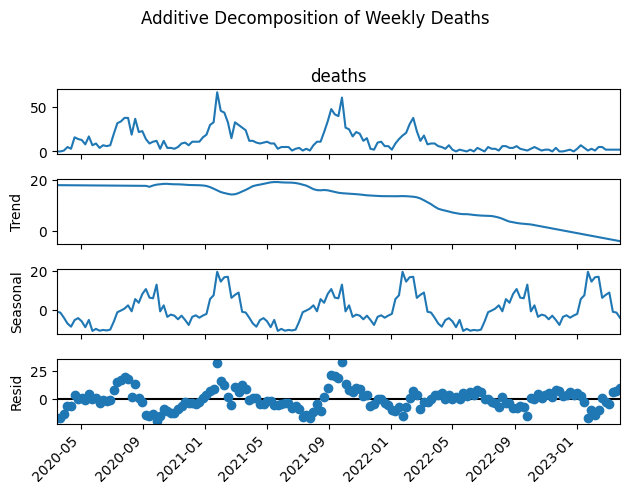


Decomposing: Weekly Deaths per 100k


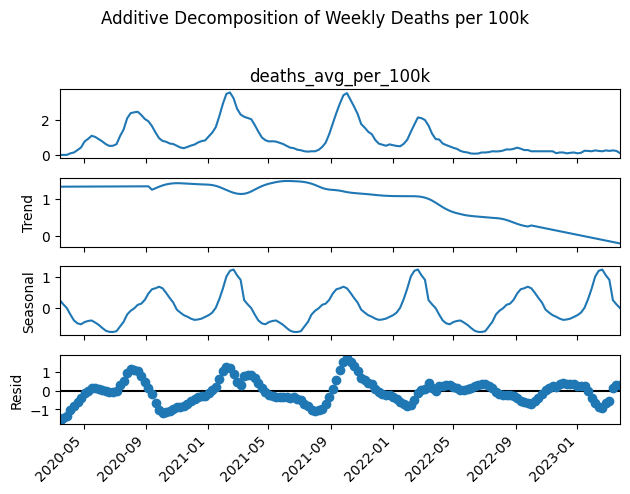

In [7]:
# Decompose and plot
series_dict = {
    "Weekly Cases": cases_df,
    "Weekly Cases per 100k": cases100k_df,
    "Weekly Deaths": deaths_df,
    "Weekly Deaths per 100k": deaths100k_df
}

for name, series in series_dict.items():
    print(f"\nDecomposing: {name}")
    
    additive = seasonal_decompose(series, model='additive', extrapolate_trend='freq')
    fig1 = additive.plot()
    fig1.suptitle(f'Additive Decomposition of {name}', y=1.02)
    for ax in fig1.axes:
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    fig1.tight_layout()
    plt.show()
    
    '''
    multiplicative = seasonal_decompose(series, model='multiplicative', extrapolate_trend='freq')
    fig2 = multiplicative.plot()
    fig2.suptitle(f'Multiplicative Decomposition of {name}', y=1.02)
    for ax in fig2.axes:
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    fig2.tight_layout()
    '''
    plt.show()


=== WEEKLY CASES ===
Cross-Validation RMSE: 4812.28


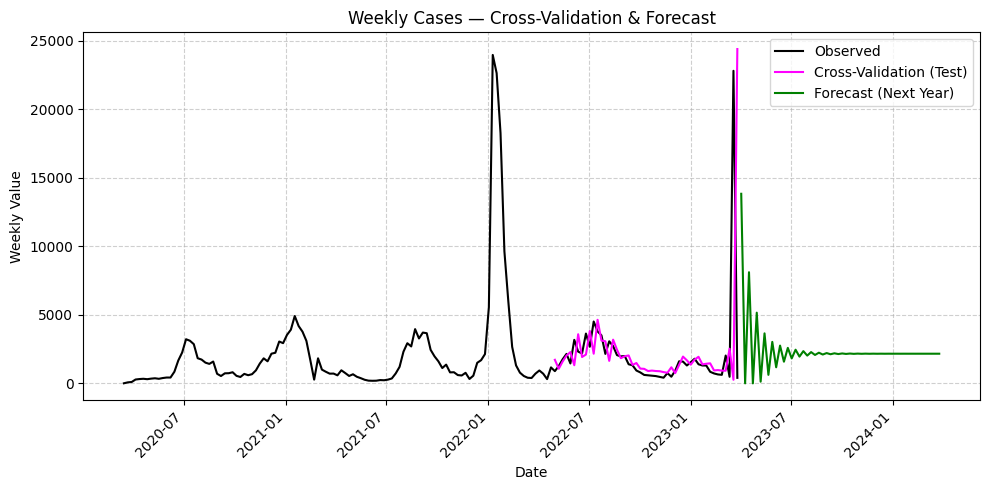


=== WEEKLY CASES PER 100K ===
Cross-Validation RMSE: 26.91


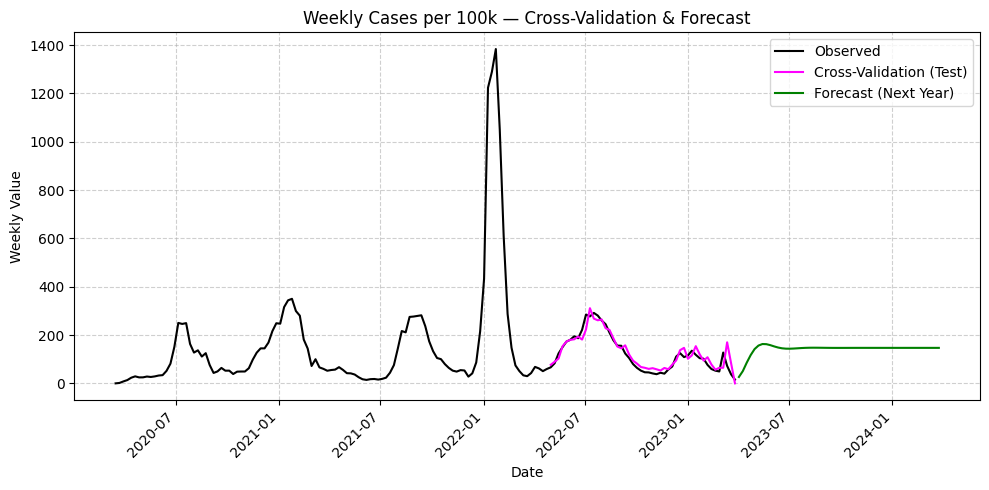


=== WEEKLY DEATHS ===
Cross-Validation RMSE: 3.11


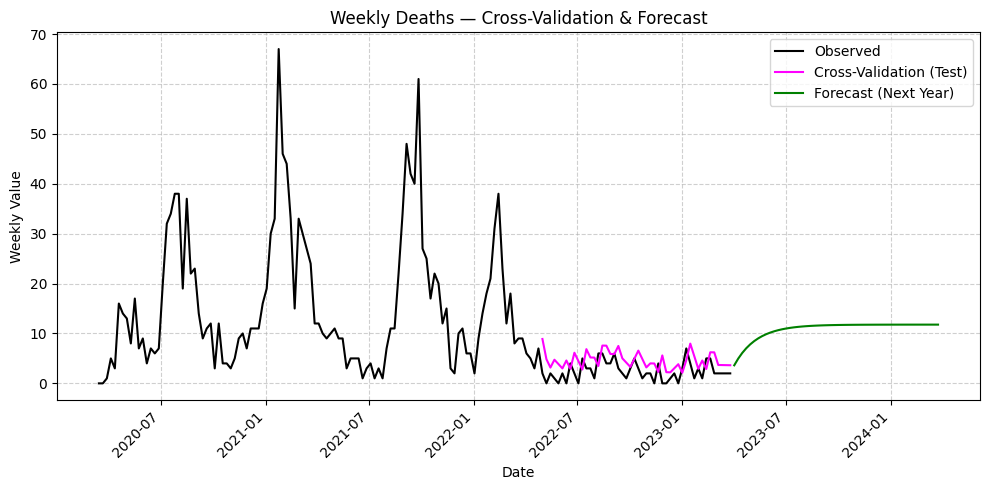


=== WEEKLY DEATHS PER 100K ===
Cross-Validation RMSE: 0.09


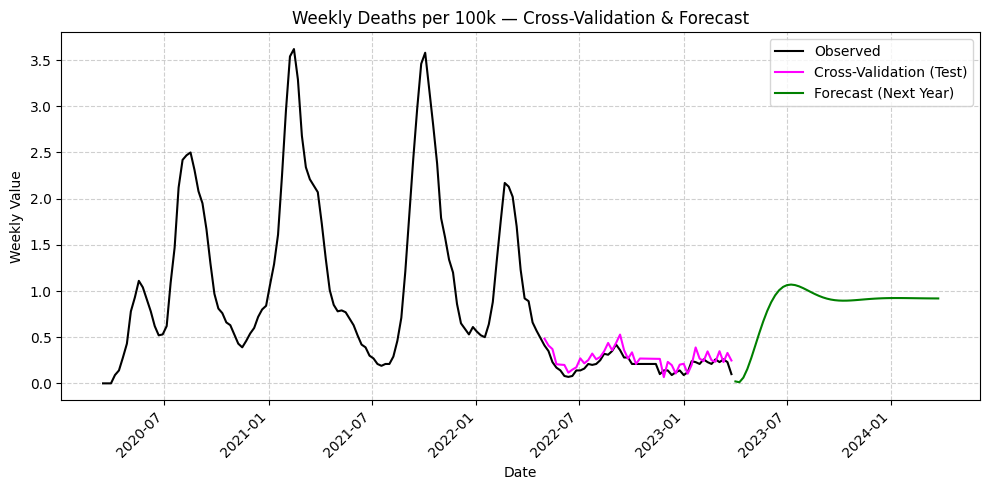

In [10]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from sklearn import metrics

# --- Helper function to cross-validate and forecast ---
def cross_validate_forecast(series, title, forecast_weeks=52, max_lag=13):
    print(f"\n=== {title.upper()} ===")
    
    # Split the data
    train = series.iloc[:int(0.7 * len(series))]
    test = series.iloc[int(0.7 * len(series)):]
    
    train_list = train.tolist()
    predictions = []
    
    # --- Cross-validation (rolling forecast) ---
    for i in range(len(test)):
        sel = ar_select_order(train_list, maxlag=max_lag, old_names=False)
        model_fit = sel.model.fit()
        pred = model_fit.predict(start=len(train_list), end=len(train_list), dynamic=False)
        predictions.append(pred[0])
        train_list.append(test.iloc[i])
    
    cross_val = pd.Series(predictions, index=test.index)
    
    # --- RMSE ---
    rmse_cv = np.sqrt(metrics.mean_squared_error(test, cross_val))
    print(f"Cross-Validation RMSE: {rmse_cv:.2f}")
    
    # --- One-year forecast (next 52 weeks) ---
    future_train = series.tolist()
    last_date = series.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=forecast_weeks, freq='W')
    
    future_predictions = []
    for i in range(forecast_weeks):
        sel = ar_select_order(future_train, maxlag=max_lag, old_names=False)
        model_fit = sel.model.fit()
        pred = model_fit.predict(start=len(future_train), end=len(future_train), dynamic=False)
        if pred[0] < 0: pred[0] = 0
        future_predictions.append(pred[0])
        future_train.append(pred[0])
    
    future_pred_series = pd.Series(future_predictions, index=future_dates)
    
    # --- Plot ---
    plt.figure(figsize=(10,5))
    plt.plot(series, label='Observed', color='black')
    plt.plot(cross_val, color='magenta', label='Cross-Validation (Test)')
    plt.plot(future_pred_series, color='green', label='Forecast (Next Year)')
    plt.title(f'{title} — Cross-Validation & Forecast')
    plt.xlabel('Date')
    plt.ylabel('Weekly Value')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return cross_val, future_pred_series, rmse_cv

# --- Run for all 4 series ---
results = {}

for name, data in {
    "Weekly Cases": cases_df,
    "Weekly Cases per 100k": cases100k_df,
    "Weekly Deaths": deaths_df,
    "Weekly Deaths per 100k": deaths100k_df
}.items():
    cross_val, future_pred, rmse = cross_validate_forecast(data, name)
    results[name] = {"cv": cross_val, "future": future_pred, "rmse": rmse}
